In [1]:
import matplotlib.pyplot as plt
import argparse
import os
import sys
# from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel, AutoConfig
import wandb
import numpy as np
import pandas as pd
import random
from collections import Counter

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


In [2]:

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/עותק של Supplementary data - responses and measures (1).csv')


Mounted at /content/drive


## Clean the text data

Remove punctuation, numbers, and special characters.
Convert text to lowercase.
Tokenize the paragraphs into words.

In [3]:

all = (df[df['Condition'].isin({'Human', '2','1','AI'})])
# set df['Condition'].isin({'Human', '2'} to 2 and df['Condition'].isin({'AI', '1'} to 1
all['Condition'] = all['Condition'].apply(lambda x: 2 if x in {'Human', '2'} else 1)

/tmp/ipython-input-1884332789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all['Condition'] = all['Condition'].apply(lambda x: 2 if x in {'Human', '2'} else 1)


In [4]:

hrel = all[['Response', 'EmpathyQ_1','Condition']]

hrel = hrel.rename(columns={"Response": "response", "EmpathyQ_1": "label",'Condition':'condition'})

hrel = hrel.dropna(subset=["response", "label"])  # Drop rows with NaN
hrel = hrel[hrel["response"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]  # Keep valid strings
hrel["label"] = hrel["label"].astype(float)  # Ensure empathy is float


# Over and Under Sampling

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

MODEL_NAME = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
POOL_BATCH = 64
MIN_CLUSTER_SIZE = 2       # m in paper (merge clusters smaller than this)
MAX_K_SEARCH = 10          # max k to try for silhouette
GENERATION_METHOD = "smote"
SMOTE_K_NEIGHBORS = 3





def extract_embeddings(text_list, batch_size=POOL_BATCH):
    embs = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Extracting embeddings"):
        batch = text_list[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
        with torch.no_grad():
            out = model(**enc, return_dict=True)
            # CLS pooling - summary of the entire sequence
            vec = out.last_hidden_state[:, 0, :].cpu().numpy()
        embs.append(vec)
    return np.vstack(embs)

def choose_k_by_silhouette(X, max_k=10):
    """
    Choose number of clusters O using silhouette score.
    Search k in [2, min(max_k, len(X))]. If len(X) < 2 -> return 1.
    """
    n = len(X)
    if n < 2:
        return 1
    upper = min(max_k, n)
    best_k = 2
    best_score = -1.0
    for k in range(2, upper + 1):
        # try-except because silhouette can fail if a label has 1 sample etc.
        try:
            km = KMeans(n_clusters=k, random_state=SEED, n_init=10).fit(X)
            labels = km.labels_
            score = silhouette_score(X, labels, metric="euclidean")
        except Exception:
            score = -1.0
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

def merge_small_clusters_iterative(X, labels, min_size=2):
    """
    Iteratively merge clusters whose size < min_size into nearest larger cluster.
    Returns updated labels (same length as input labels).
    """
    labels_updated = labels.copy()
    unique = np.unique(labels_updated)
    while True:
        counts = {c: int(np.sum(labels_updated == c)) for c in unique}
        small = [c for c, s in counts.items() if s < min_size]
        if not small or len(unique) == 1:
            break
        large = [c for c in unique if c not in small]
        if not large:
            break
        for sc in small:
            sc_idx = np.where(labels_updated == sc)[0]
            # centroid of small cluster
            sc_centroid = X[sc_idx].mean(axis=0).reshape(1, -1)
            # compute centroids for 'large' clusters
            large_centroids = np.array([X[labels_updated == lc].mean(axis=0) for lc in large])
            nearest = np.argmin(np.linalg.norm(large_centroids - sc_centroid, axis=1))
            target = large[nearest]
            labels_updated[sc_idx] = target
        unique = np.unique(labels_updated)
    # re-index cluster ids to compact range (optional)
    # map old labels to new sequential labels
    unique = np.unique(labels_updated)
    mapping = {old: new for new, old in enumerate(unique)}
    labels_mapped = np.array([mapping[l] for l in labels_updated])
    return labels_mapped


def hc_bou_balance(hrel_df,
                   pool_batch=POOL_BATCH,
                   min_cluster_size=MIN_CLUSTER_SIZE,
                   max_k_search=MAX_K_SEARCH,
                   generation_method=GENERATION_METHOD,
                   smote_k_neighbors=SMOTE_K_NEIGHBORS):

    texts = hrel_df['response'].astype(str).tolist()
    embeddings = extract_embeddings(texts, batch_size=pool_batch)

    unique_conditions = sorted(hrel_df['condition'].unique())
    balanced_rows = []       # list of dicts (rows)
    balanced_embs = []       # list of embeddings aligned with balanced_rows
    cluster_log = {}
    for cond in unique_conditions:
        cond_mask = (hrel_df['condition'] == cond).values
        cond_global_idx = np.where(cond_mask)[0]
        cond_X = embeddings[cond_mask]
        cond_y = hrel_df.loc[cond_mask, 'label'].values

        N = len(cond_y)
        classes = np.unique(cond_y)
        C = len(classes)
        if C == 0:
            continue
        S = int(round(N / C))  # target per-class size after balancing
        cluster_log[cond] = {}

        for cls in classes:
            cls_mask_local = (cond_y == cls)
            if not np.any(cls_mask_local):
                continue
            cls_X = cond_X[cls_mask_local]
            cls_global_idx = cond_global_idx[cls_mask_local]  # global indices in hrel_df
            cls_n = len(cls_X)

            cluster_log[cond][int(cls)] = {}

            if cls_n >= S:
                # Majority: undersample with KMeans(n_clusters=S), pick nearest-to-centroid samples
                n_clusters = S
                km = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10).fit(cls_X)
                centers = km.cluster_centers_
                closest_local, _ = pairwise_distances_argmin_min(centers, cls_X)
                chosen_global = cls_global_idx[closest_local]

                # add chosen real rows
                for g in chosen_global:
                    row = hrel_df.iloc[g].to_dict()
                    row["_orig_index"] = int(g)
                    row["_is_synthetic"] = False
                    balanced_rows.append(row)
                    balanced_embs.append(embeddings[g])

                cluster_log[cond][int(cls)]["type"] = "majority_undersampled"
                cluster_log[cond][int(cls)]["kept_count"] = int(len(chosen_global))

            else:
                # Minority: choose O via silhouette, cluster into O, merge small clusters,
                # compute W_m and hat_S_m as in paper, then generate hat_S_m samples per cluster.
                if cls_n < 2:
                    labels_after = np.zeros(cls_n, dtype=int)
                    counts_after = {0: cls_n}
                else:
                    O = choose_k_by_silhouette(cls_X, max_k=min(max_k_search, cls_n))
                    km = KMeans(n_clusters=O, random_state=SEED, n_init=10).fit(cls_X)
                    labels = km.labels_
                    labels_after = merge_small_clusters_iterative(cls_X, labels, min_size=min_cluster_size)
                    unique_after = np.unique(labels_after)
                    counts_after = {int(c): int(np.sum(labels_after == c)) for c in unique_after}

                total_after = sum(counts_after.values())
                Wm = {c: counts_after[c] / total_after for c in counts_after}

                #hat_S_m = floor( W_m * (S - C_m) )
                per_cluster_hat = {}
                for c in counts_after:
                    C_m = counts_after[c]
                    rem = S - C_m
                    hat_S_m = int(np.floor(Wm[c] * rem))
                    per_cluster_hat[c] = hat_S_m

                # adjust rounding so we reach desired extra
                desired_extra = S - total_after
                sum_generated = sum(per_cluster_hat.values())
                diff = desired_extra - sum_generated
                if diff > 0:
                    order = sorted(per_cluster_hat.keys(), key=lambda c: -Wm[c])
                    i = 0
                    while diff > 0:
                        per_cluster_hat[order[i % len(order)]] += 1
                        diff -= 1
                        i += 1
                elif diff < 0:
                    order = sorted(per_cluster_hat.keys(), key=lambda c: Wm[c])
                    i = 0
                    while diff < 0:
                        c0 = order[i % len(order)]
                        if per_cluster_hat[c0] > 0:
                            per_cluster_hat[c0] -= 1
                            diff += 1
                        i += 1

                # keep all original minority samples (real)
                for g in cls_global_idx:
                    row = hrel_df.iloc[g].to_dict()
                    row["_orig_index"] = int(g)
                    row["_is_synthetic"] = False
                    balanced_rows.append(row)
                    balanced_embs.append(embeddings[g])

                # generate hat_S_m per cluster
                for c, n_gen in per_cluster_hat.items():
                    if n_gen <= 0:
                        continue
                    members_local = np.where(labels_after == c)[0]
                    if len(members_local) == 0:
                        continue
                    members_global = cls_global_idx[members_local]

                    if len(members_local) > 1:
                        k_neighbors = min(smote_k_neighbors, max(1, len(members_local)-1))
                        X_cluster = cls_X[members_local]
                        # We want to create exactly n_gen synthetic samples.
                        # SMOTE generates until a target count; create target = len(X_cluster) + n_gen
                        target = len(X_cluster) + n_gen
                        try:
                            sm = SMOTE(sampling_strategy={0: target}, k_neighbors=k_neighbors, random_state=SEED)
                            y_dummy = np.zeros(len(X_cluster))
                            X_res, _ = sm.fit_resample(X_cluster, y_dummy)
                            # generated embeddings are X_res[len(X_cluster):]
                            new_embs = X_res[len(X_cluster):]
                            if len(new_embs) < n_gen:
                                # fallback: pad by duplicating members
                                needed = n_gen - len(new_embs)
                                chosen = np.random.choice(members_global, size=needed, replace=True)
                                for g in chosen:
                                    row = hrel_df.iloc[g].to_dict()
                                    row["_orig_index"] = int(g)
                                    row["_is_synthetic"] = False
                                    balanced_rows.append(row)
                                    balanced_embs.append(embeddings[g])
                            # append created synthetic embeddings (create synthetic rows)
                            for emb in new_embs:
                                row = {"response": None, "label": float(cls), "condition": cond}
                                row["_orig_index"] = -1
                                row["_is_synthetic"] = True
                                balanced_rows.append(row)
                                balanced_embs.append(emb)
                        except Exception:
                            # fallback to duplication if SMOTE fails
                            chosen = np.random.choice(members_global, size=n_gen, replace=True)
                            for g in chosen:
                                row = hrel_df.iloc[g].to_dict()
                                row["_orig_index"] = int(g)
                                row["_is_synthetic"] = False
                                balanced_rows.append(row)
                                balanced_embs.append(embeddings[g])

                # log info
                cluster_log[cond][int(cls)]['type'] = 'minority_oversampled'
                cluster_log[cond][int(cls)]['counts_after_merge'] = counts_after
                cluster_log[cond][int(cls)]['Wm'] = {int(k): float(v) for k, v in Wm.items()}
                cluster_log[cond][int(cls)]['generated_per_cluster'] = {int(k): int(v) for k, v in per_cluster_hat.items()}

    # build balanced DataFrame and embeddings array
    balanced_df = pd.DataFrame(balanced_rows).reset_index(drop=True)
    balanced_embeddings = np.vstack(balanced_embs) if len(balanced_embs) > 0 else np.zeros((0, embeddings.shape[1]))

    return balanced_df, balanced_embeddings, cluster_log

# Run HCBOU balancing

train_df, test_df = train_test_split(
    hrel,
    test_size=0.2,
    stratify=hrel['label'],   # keep original label distribution
    random_state=SEED)


balanced_df, balanced_embeddings, cluster_log = hc_bou_balance(
    train_df,
    pool_batch=64,
    min_cluster_size=2,
    max_k_search=10,
    generation_method="smote",
    smote_k_neighbors=3
)

print("Original size:", len(hrel))
print("Balanced size:", len(balanced_df))
print(balanced_df['label'].value_counts())



Extracting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

Original size: 2494
Balanced size: 2000
label
0.0    200
1.0    200
2.0    200
3.0    200
4.0    200
5.0    200
6.0    200
7.0    200
8.0    200
9.0    200
Name: count, dtype: int64


In [ ]:
test_embs = extract_embeddings(test_df['response'].astype(str).tolist(), batch_size=POOL_BATCH)

Extracting embeddings:   0%|          | 0/8 [00:00<?, ?it/s]

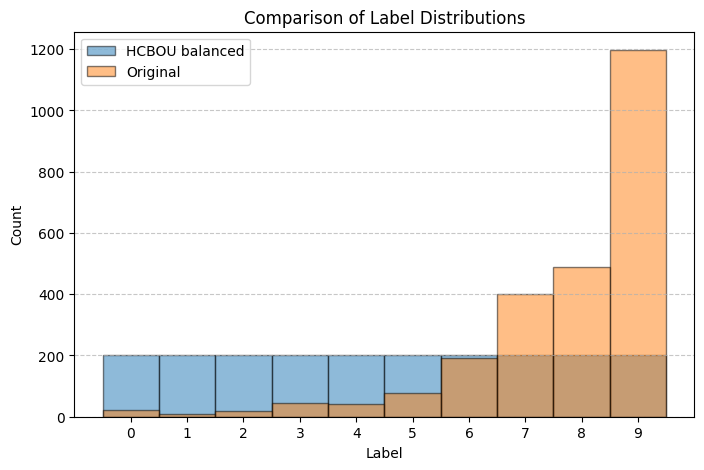

In [ ]:

# Determine common bin edges for both datasets
all_labels = np.concatenate([balanced_df['label'], hrel['label']])
bins = np.arange(all_labels.min(), all_labels.max() + 2) - 0.5  # For discrete labels

plt.figure(figsize=(8,5))
plt.hist(balanced_df['label'], bins=bins, alpha=0.5, label='HCBOU balanced', edgecolor='black')
plt.hist(hrel['label'], bins=bins, alpha=0.5, label='Original', edgecolor='black')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Comparison of Label Distributions')
plt.xticks(np.arange(all_labels.min(), all_labels.max()+1))  # Ensure ticks align with bins
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Baseline with HCBOU



In [ ]:

def run_random_forest(X_train, X_test, y_train, y_test ):

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    clf.feature_importances_
    return y_test, y_pred


def run_xgboost(X_train, X_test, y_train, y_test , feature_type: str):

    xgb_model = XGBClassifier(
    objective='multi:softprob',  # Softmax with probabilities
    num_class=10,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=500,
    learning_rate=0.05,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10
    )

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    beta = 2
    f_beta = fbeta_score(y_test, y_pred, beta=beta, average="weighted")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"F-{beta} score: {f_beta:.2f}")

    plt.figure(figsize=(8, 5))
    ax = plot_importance(xgb_model, importance_type='gain', title=title, max_num_features=10)
    for text in ax.texts:
        text.set_visible(False)
    plt.tight_layout()
    plt.show()


    return y_pred, y_test, X_train, X_test, y_train, xgb_model

In [ ]:
def create_conf_matrix(y_test, y_pred, model_name: str):
    conf_mat = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()
    disp.ax_.set_title(f"{model_name}")
    plt.show()

Accuracy: 0.250501002004008
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00         8
         5.0       0.00      0.00      0.00        15
         6.0       0.06      0.15      0.09        39
         7.0       0.20      0.28      0.23        80
         8.0       0.20      0.32      0.24        98
         9.0       0.52      0.28      0.36       240

    accuracy                           0.25       499
   macro avg       0.10      0.10      0.09       499
weighted avg       0.32      0.25      0.26       499



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


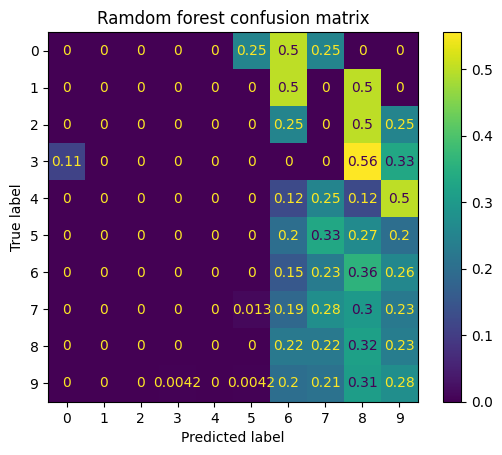

In [ ]:
rf_y_test, rf_y_pred = run_random_forest(balanced_embeddings, test_embs, balanced_df['label'], test_df['label'])
create_conf_matrix(rf_y_test, rf_y_pred, "Ramdom forest with HCBOU confusion matrix")

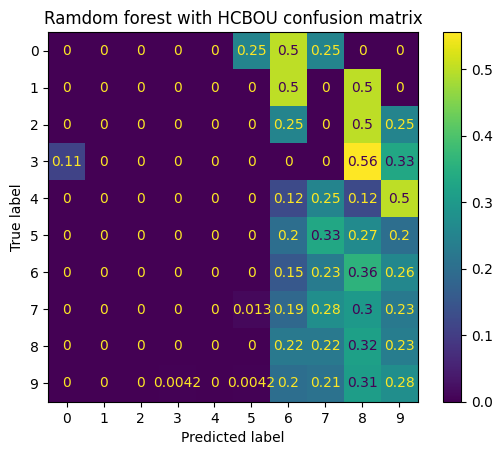

In [ ]:
create_conf_matrix(rf_y_test, rf_y_pred, "Ramdom forest with HCBOU confusion matrix")

# classifying into binary classes high & low

In [ ]:
low = hrel[hrel["label"] <=6]
low['label'] = 0
high = hrel[hrel["label"] >6]
high['label'] = 1
df_sep = pd.concat([low, high])

/tmp/ipython-input-383299899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['label'] = 0
/tmp/ipython-input-383299899.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['label'] = 1


In [ ]:
train_df, test_df = train_test_split(
    df_sep,
    test_size=0.2,
    stratify=df_sep['label'],   # keep original label distribution
    random_state=SEED)


balanced_df, balanced_embeddings, cluster_log = hc_bou_balance(
    train_df,
    pool_batch=64,
    min_cluster_size=2,
    max_k_search=10,
    generation_method="smote",
    smote_k_neighbors=3
)

print("Original size:", len(hrel))
print("Balanced size:", len(balanced_df))
print(balanced_df['label'].value_counts())
test_embs = extract_embeddings(test_df['response'].astype(str).tolist(), batch_size=POOL_BATCH)



Extracting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

Original size: 2494
Balanced size: 1996
label
0    998
1    998
Name: count, dtype: int64


Extracting embeddings:   0%|          | 0/8 [00:00<?, ?it/s]

Accuracy: 0.8076152304609219
              precision    recall  f1-score   support

           0       0.26      0.10      0.14        81
           1       0.84      0.94      0.89       418

    accuracy                           0.81       499
   macro avg       0.55      0.52      0.52       499
weighted avg       0.75      0.81      0.77       499



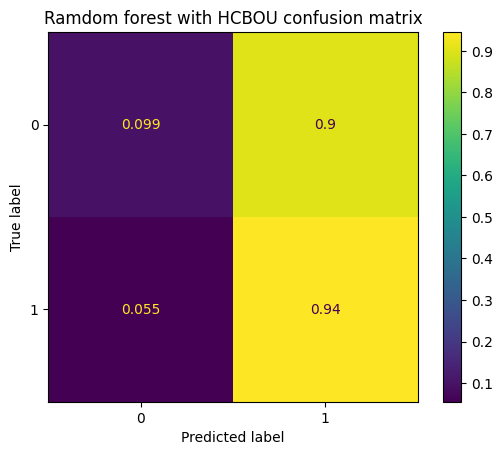

In [ ]:
rf_y_test, rf_y_pred = run_random_forest(balanced_embeddings, test_embs, balanced_df['label'], test_df['label'])
create_conf_matrix(rf_y_test, rf_y_pred, "Ramdom forest with HCBOU confusion matrix")